## Load packages

In this section, we import the essential packages and libraries required for building the image classification model using transfer learning. These packages provide tools for data manipulation, image visualization, and constructing the model with Keras. Together, they enable data preprocessing, the creation of custom layers, and the adaptation of pre-trained networks for our specific task.

Packages used:

* `os` and `random`: For file handling and ensuring experiment reproducibility.
* `numpy`: For mathematical operations and array manipulation.
* `keras`: The primary library for building and training neural networks.
* `matplotlib`: For visualization.

In [ ]:
import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense
from keras.models import Model

## Functions

In this section, we define a helper function to streamline the process of loading and preparing images for the model. This function takes the file path of an image, resizes it to the required dimensions for the pre-trained network, and preprocesses it into a suitable input format. By encapsulating these steps in a single function, we ensure cleaner and more reusable code.

In [42]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

This function is essential for ensuring the images are in the correct format and dimensions expected by the network, making the workflow more efficient and error-free.

## Load Data

In this section, we handle the preparation of the dataset required for training the model. The process involves several key steps to ensure the data is well-organized and ready for input into the neural network.

Each category is represented by a folder containing the respective images. For this project, the folders represent the distinct classes we aim to classify

In [43]:
root = 'Images'

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['Images\\Chad Smith', 'Images\\Will Ferrell']


We divided all the data into three subsets -- a training set `train`, a validation set `val`, and a test set `test`. The reason for this is to properly evaluate the accuracy of our classifier. During training, the optimizer uses the validation set to evaluate its internal performance, in order to determine the gradient without overfitting to the training set. The `test` set is always held out from the training algorithm, and is only used at the end to evaluate the final accuracy of our model.

In [44]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomize the data order.

In [45]:
random.shuffle(data)

Create training / validation / test split (70%, 15%, 15%)

In [46]:
train_split, val_split = 0.7, 0.15

idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separate data for labels.

In [47]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0]


Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

The pixel values of the images are normalized to improve the convergence of the training process.
Labels are converted to one-hot vectors to ensure compatibility with the output layer of the network

In [48]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(30, 2)


Let's get a summary of what we have.

In [49]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 200 images from 2 categories
train / validation / test split: 140, 30, 30
training data shape:  (140, 224, 224, 3)
training labels shape:  (140, 2)


Let's quickly look at a few sample images from our dataset.

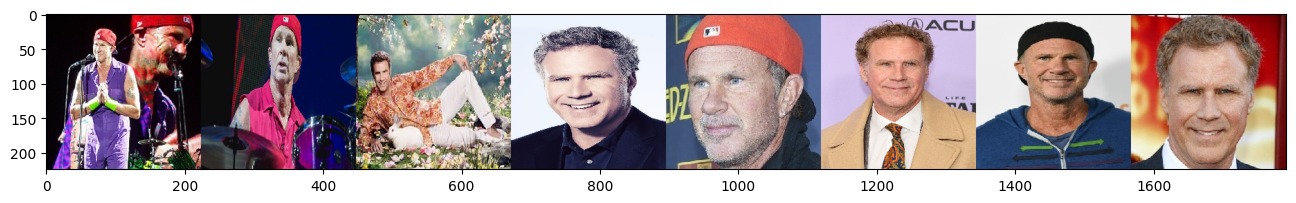

In [50]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

## Transfer learning by starting with existing network

In this section, we leverage the power of transfer learning by utilizing a pre-trained neural network to kickstart our classification task. Specifically, we use the VGG16 model from Keras, which has been pre-trained on the extensive ImageNet dataset. This model provides a robust foundation due to its ability to extract meaningful features from images.

Once the network is loaded, we can inspect the layers with the `summary()` method.

In [51]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

To adapt the network for our specific classification task:

* The original fully connected layers of VGG16 are replaced.
* A new Dense layer is added, corresponding to the number of categories in our dataset.
* The final layer uses a softmax activation function for multiclass classification.

In [52]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

To retain the knowledge learned from ImageNet, the layers of the convolutional base are frozen, ensuring that only the newly added layers are trained on our dataset.

In [53]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

The model was trained using the following configuration:

* Batch Size: 128
* Epochs: 50
* Training Data: x_train and y_train
* Validation Data: x_val and y_val

In [54]:
history = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=50,
                         validation_data=(x_val, y_val))

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.5100 - loss: 1.0662 - val_accuracy: 0.6000 - val_loss: 0.7430
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.5264 - loss: 0.8442 - val_accuracy: 0.4000 - val_loss: 1.4099
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step - accuracy: 0.5247 - loss: 1.1858 - val_accuracy: 0.4000 - val_loss: 1.2561
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - accuracy: 0.5169 - loss: 1.0584 - val_accuracy: 0.6333 - val_loss: 0.6029
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step - accuracy: 0.6400 - loss: 0.6603 - val_accuracy: 0.6000 - val_loss: 0.7210
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - accuracy: 0.4805 - loss: 0.8747 - val_accuracy: 0.7333 - val_loss: 0.5739
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - accuracy: 0.6842 - loss: 0.6129 - val_accuracy: 0.4333 - val_loss: 0.8014
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.5247 - loss: 0.7018 - val_accuracy: 0.5000 - val_loss: 0.7340
Epoch 9/

Plotting the loss and accuracy, we see that the model improves over the epochs.

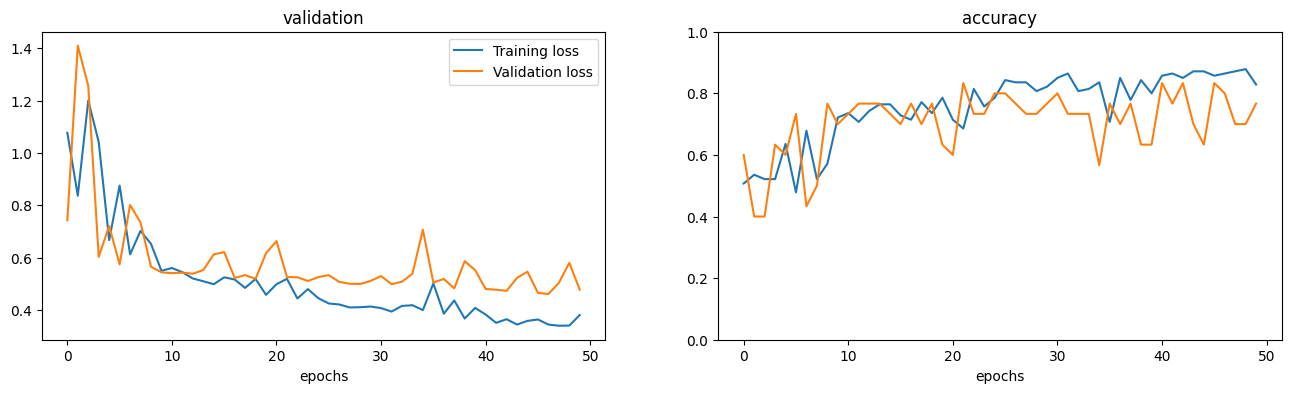

In [55]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["loss"], label="Training loss")
ax.plot(history.history["val_loss"], label="Validation loss")
ax.set_title("validation")
ax.set_xlabel("epochs")
ax.legend()

ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"], label="Training accuracy")
ax2.plot(history.history["val_accuracy"], label="Validation accuracy")
ax2.set_title("accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

After training the modified VGG16 model on our dataset, the results indicate that the model learned to distinguish between the categories. The performance metrics on the test dataset are as follows:

In [57]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.5555726289749146
Test accuracy: 0.6666666865348816


## Improving the results


In this project, we successfully applied transfer learning using the pre-trained VGG16 model, fine-tuning it for the task of classifying images of two distinct individuals, Will Ferrell and Chad Smith.

However, there is room for improvement. Here are some potential strategies to enhance the model's performance:

* More Training Data
* More Epochs
* Different models
* Data Augmentation
* Fine-tuning More Layers
* Hyperparameter Tuning

By applying these improvements, we can expect the model to achieve higher accuracy and generalization, making it more effective at distinguishing between Will Ferrell and Chad Smith with even greater precision.